# Задание
Обучить детектор объектов с помощью **TensorFlow Object Detection API**

## Imports


In [1]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.2f}'.format)

In [2]:
import tensorflow_hub as hub
import tensorflow as tf
from six.moves.urllib.request import urlopen
from IPython.display import Image as IPyImage
from IPython.display import display, Javascript
from PIL import Image, ImageDraw, ImageFont
from six import BytesIO
import numpy as np
import scipy.misc
import io
import os
import pathlib
import random
import imageio
import glob

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

***************************

In [3]:
# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone - -depth 1 https: // github.com/tensorflow/models

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Intalling the Object Detection API

In [17]:
# # Install the Object Detection API
# %%bash
# cd models/research/
# protoc object_detection/protos/*.proto --python_out=.
# cp object_detection/packages/tf2/setup.py .
# python -m pip install .

In [6]:
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

## UTILS

In [7]:
def load_image_into_numpy_array(path):

    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)


def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None,
                    min_score_thresh=0.5):

    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=min_score_thresh)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

## Load images and visualize

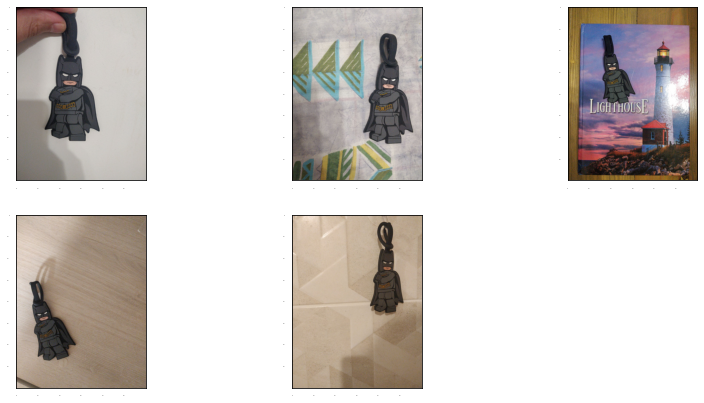

In [18]:
%matplotlib inline

train_image_dir = '/content/drive/MyDrive/HW_5/train'
train_images_np = []
for i in range(1, 6):
    image_path = os.path.join(train_image_dir, str(i) + '.jpg')
    train_images_np.append(load_image_into_numpy_array(image_path))

plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = False
plt.rcParams['ytick.labelsize'] = False
plt.rcParams['xtick.top'] = False
plt.rcParams['xtick.bottom'] = False
plt.rcParams['ytick.left'] = False
plt.rcParams['ytick.right'] = False
plt.rcParams['figure.figsize'] = [14, 7]

for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

In [9]:
# colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

In [10]:
gt_boxes = [np.array([[0.27, 0.21333333, 0.78, 0.645]], dtype=np.float32),
            np.array([[0.31166667, 0.54, 0.79166667, 0.935]],
                     dtype=np.float32),
            np.array([[0.27166667, 0.26333333, 0.56, 0.52]], dtype=np.float32),
            np.array(
                [[0.49666667, 0.11166667, 0.85166667, 0.47166667]], dtype=np.float32),
            np.array([[0.18666667, 0.59333333, 0.57, 0.86333333]],
                     dtype=np.float32)
            ]

In [11]:
btm_class_id = 1
num_classes = 1

category_index = {btm_class_id: {'id': btm_class_id, 'name': 'batman'}}

label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np) in zip(
        train_images_np, gt_boxes):
    train_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(
        train_image_np, dtype=tf.float32), axis=0))
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    zero_indexed_groundtruth_classes = tf.convert_to_tensor(
        np.ones(shape=[gt_box_np.shape[0]], dtype=np.int32) - label_id_offset)
    gt_classes_one_hot_tensors.append(tf.one_hot(
        zero_indexed_groundtruth_classes, num_classes))

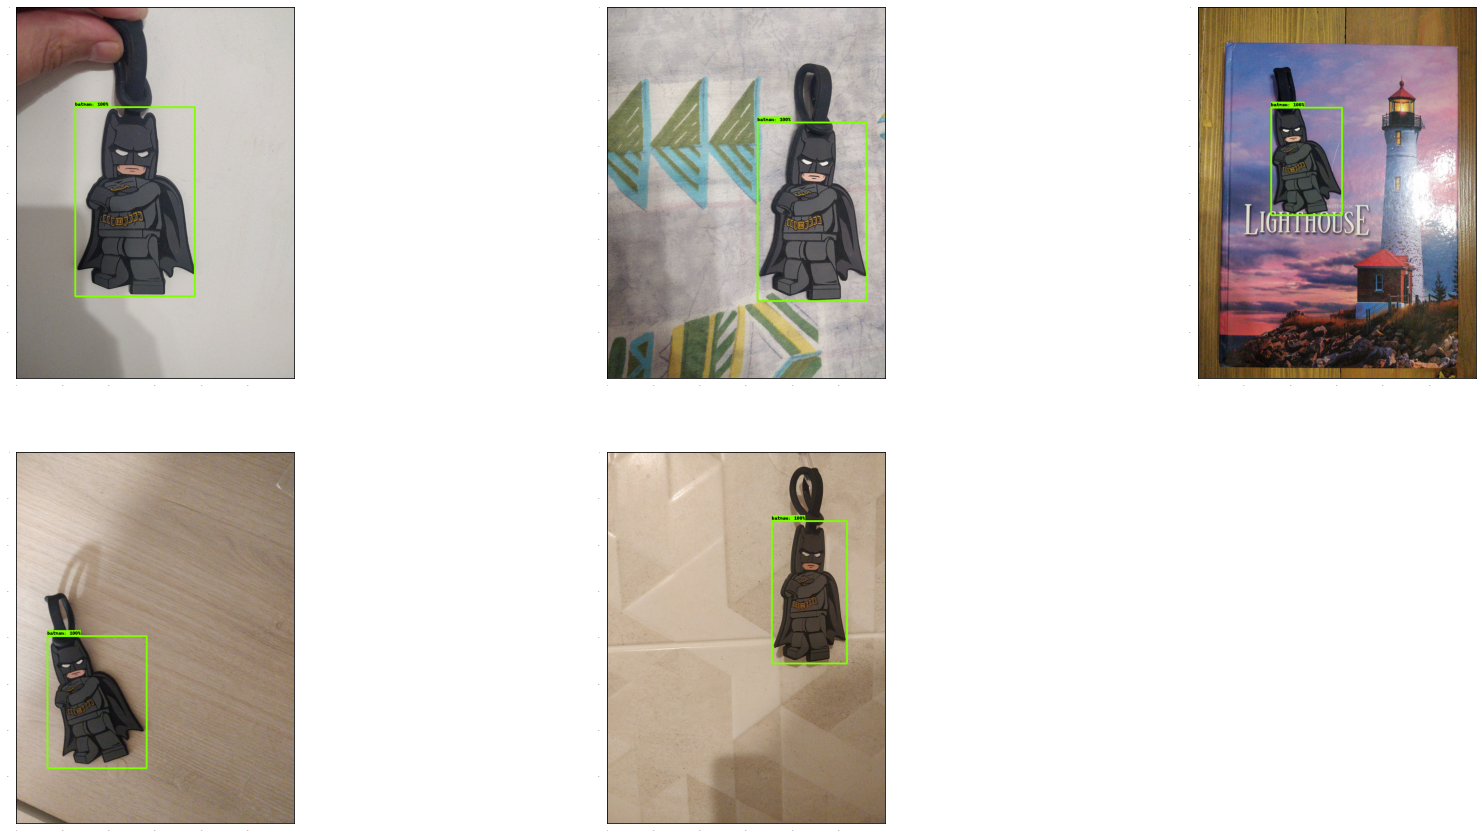

In [12]:
%matplotlib inline
dummy_scores = np.array([1.0], dtype=np.float32)  # give boxes a score of 100%

plt.figure(figsize=(30, 15))
for idx in range(5):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        np.ones(shape=[gt_boxes[idx].shape[0]], dtype=np.int32),
        dummy_scores, category_index)
plt.show()

## LOAD MODEL

In [ ]:
# Download the checkpoint and put it into models/research/object_detection/test_data/

!wget http: // download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!tar - xf ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
!mv ssd_resnet50_v1_fpn_640x640_coco17_tpu-8/checkpoint models/research/object_detection/test_data/

--2021-08-29 17:47:15--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.202.128, 2607:f8b0:4001:c06::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.202.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.10’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M   278MB/s    in 0.8s    

2021-08-29 17:47:16 (278 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz.10’ saved [244817203/244817203]



In [13]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning...', flush=True)
num_classes = 1
pipeline_config = 'models/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config'
checkpoint_path = 'models/research/object_detection/test_data/checkpoint/ckpt-0'

configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True
detection_model = model_builder.build(
    model_config=model_config, is_training=True)

fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(checkpoint_path).expect_partial()

image, shapes = detection_model.preprocess(tf.zeros([1, 640, 640, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning...
Weights restored!


## TRAINING

In [14]:
tf.keras.backend.set_learning_phase(True)
batch_size = 5
learning_rate = 0.01
num_batches = 40

trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
    'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead']
for var in trainable_variables:
    if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
        to_fine_tune.append(var)

# Set up forward + backward pass for a single train step.


def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):

        shapes = tf.constant(batch_size * [[640, 640, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list)
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0]
                 for image_tensor in image_tensors], axis=0)
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + \
                losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss

    return train_step_fn


optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune)

print('Start fine-tuning!', flush=True)
for idx in range(1, num_batches+1):
    # Grab keys for a random subset of examples
    all_keys = list(range(len(train_images_np)))
    random.shuffle(all_keys)
    example_keys = all_keys[:batch_size]
    gt_boxes_list = [gt_box_tensors[key] for key in example_keys]
    gt_classes_list = [gt_classes_one_hot_tensors[key] for key in example_keys]
    image_tensors = [train_image_tensors[key] for key in example_keys]
    total_loss = train_step_fn(image_tensors, gt_boxes_list, gt_classes_list)

    if (idx % 10) == 0 or (idx == num_batches):
        print('batch ' + str(idx) + ' of ' + str(num_batches)
              + ', loss=' + str(total_loss.numpy()), flush=True)

print('Done fine-tuning!')

Start fine-tuning!
batch 10 of 40, loss=0.3426646
batch 20 of 40, loss=0.11386342
batch 30 of 40, loss=0.042534668
batch 40 of 40, loss=0.01860024
Done fine-tuning!


## TEST DETECTION

In [15]:
test_image_dir = '/content/drive/MyDrive/HW_5/test'
test_images_np = []
for i in range(1, 3):
    image_path = os.path.join(test_image_dir, str(i) + '.jpg')
    test_images_np.append(np.expand_dims(
        load_image_into_numpy_array(image_path), axis=0))

# Again, uncomment this decorator if you want to run inference eagerly


@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

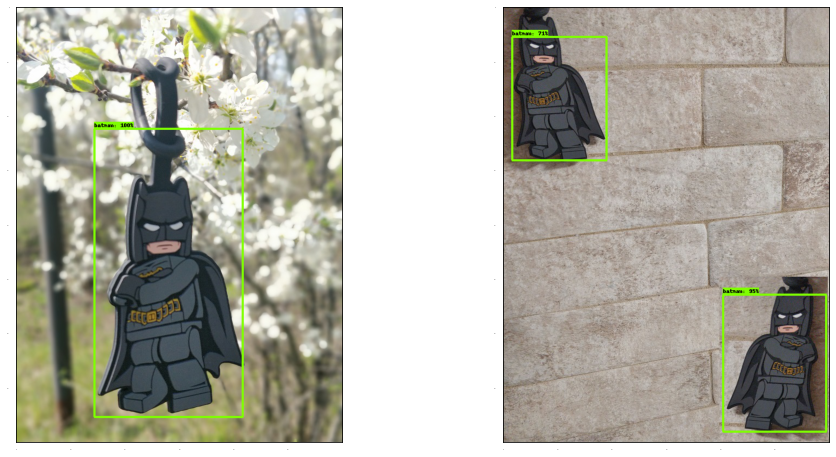

In [25]:
%matplotlib inline
plt.figure(figsize=(16, 8))
label_id_offset = 1
for i in range(len(test_images_np)):
    input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
    detections = detect(input_tensor)
    plt.subplot(1, 2, i+1)
    plot_detections(
        test_images_np[i][0],
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.uint32)
        + label_id_offset,
        detections['detection_scores'][0].numpy(),
        category_index, figsize=(30, 15), image_name=None)
plt.show()